# Google Pixel Watch 3 energy expenditure analysis: Bland-Alt, MAPE, MAE

## Bland-Altman limits of agreement analysis & plot

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t
from scipy import stats
import plotly.express as px

In [2]:
file_path = 'pixel_ee_data.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,participant_id,test_date,test_time,Google Pixel Watch model,VO2max attained?,VO2max 30s lab score (ml/min/kg),Google Pixel Watch VO2 max prediction,GP cardio fit prediction date,EEtot kcal Cosmed,total kcal own GP (from VO2 max test),include_vo2,include_in_hr_analysis,include_in_ee_analysis
0,rory p1,13/2/25,12:50,3,Yes,46.41,48,13/2/25,197,251,y,y,y
1,rory p2,25/2/25,11:00,3,Yes,56.59,55,13/2/25,289,299,y,y,y
2,rory p3,25-02-2025,11:40,3,Yes,63.77,70,25/2/25,210,119,y,y,y
3,rory p4,11/3/25,12:30,3,No,no,-,-,-,-,n,y,n
4,rory p5,11/3/25,13:30,3,Yes,52.59,48,11/3/25,247,277,y,y,y


In [4]:
df.shape

(34, 13)

In [5]:
df = df[['participant_id', 'EEtot kcal Cosmed', 'total kcal own GP (from VO2 max test)', 'include_in_ee_analysis']]

In [6]:
df.head()

,participant_id,EEtot kcal Cosmed,total kcal own GP (from VO2 max test),include_in_ee_analysis
0,rory p1,197,251,y
1,rory p2,289,299,y
2,rory p3,210,119,y
3,rory p4,-,-,n
4,rory p5,247,277,y


In [7]:
df = df.loc[df['include_in_ee_analysis'].str.strip() != 'n']

In [8]:
df.shape

(30, 4)

In [9]:
df = df.rename(
    columns={'EEtot kcal Cosmed' : 'cosmed_ee', 'total kcal own GP (from VO2 max test)' : 'pixel_ee'}
)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 33
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   participant_id          30 non-null     object
 1   cosmed_ee               30 non-null     object
 2   pixel_ee                30 non-null     object
 3   include_in_ee_analysis  30 non-null     object
dtypes: object(4)
memory usage: 1.2+ KB


In [11]:
df['pixel_ee'] = pd.to_numeric(df['pixel_ee'])

In [12]:
df['cosmed_ee'] = pd.to_numeric(df['cosmed_ee'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, 0 to 33
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   participant_id          30 non-null     object
 1   cosmed_ee               30 non-null     int64 
 2   pixel_ee                30 non-null     int64 
 3   include_in_ee_analysis  30 non-null     object
dtypes: int64(2), object(2)
memory usage: 1.2+ KB


In [14]:
# Calculate Bland-Altman statistics
mean_diff_values = (df['cosmed_ee'] + df['pixel_ee']) / 2 # this is just for the BA plot
diff = df['pixel_ee'] - df['cosmed_ee'] # important to note than mean diff is normally calculated as index measure - criterion for Bland-Altman
mean_diff = diff.mean()
std_diff = diff.std()

In [15]:
# Calculate standard error
n = len(diff)
se_diff = std_diff / np.sqrt(n)

In [16]:
# Calculate limits of agreement
loa_upper = mean_diff + 1.96 * std_diff
loa_lower = mean_diff - 1.96 * std_diff

In [17]:
# Calculate 95% CI for the mean difference
ci_upper = mean_diff + 1.96 * se_diff
ci_lower = mean_diff - 1.96 * se_diff

In [18]:
# Calculate mean and standard deviation for Cosmed and Apple Watch
mean_cosmed = df['cosmed_ee'].mean()
cosmed_std = df['cosmed_ee'].std()
mean_pixel = df['pixel_ee'].mean()
pixel_std = df['pixel_ee'].std()

In [19]:
# Calculate standard error for Cosmed and Apple Watch
se_cosmed = cosmed_std / np.sqrt(n)
se_pixel = pixel_std / np.sqrt(n)

In [20]:
# Calculate 95% CI for the upper and lower limits of agreement
## First calculate standard error of the loa
se_loa = std_diff * (np.sqrt((1/n) + ((1.96 ** 2) / (2 * (n - 1)))))
print(f"SE LoA: {se_loa:.4f}")
## Then calculate 95% CI
ci_lowerbound_upper_loa = loa_upper - 1.96 * se_loa
ci_upperbound_upper_loa = loa_upper + 1.96 * se_loa
ci_lowerbound_lower_loa = loa_lower - 1.96 * se_loa
ci_upperbound_lower_loa = loa_lower + 1.96 * se_loa
print(f"95% CI of lower LoA: ({ci_lowerbound_lower_loa:.4f}, {ci_upperbound_lower_loa:.4f})")
print(f"95% CI of upper LoA: ({ci_lowerbound_upper_loa:.4f}, {ci_upperbound_upper_loa:.4f})")

SE LoA: 10.3545
95% CI of lower LoA: (-93.0450, -52.4554)
95% CI of upper LoA: (35.5887, 76.1783)


In [21]:
# Print results
print(f"The number of participants was: {len(diff)} \n--")
print(f"Mean Cosmed: {mean_cosmed:.2f} ml/min/kg.\nMean Pixel Watch: {mean_pixel:.2f} ml/min/kg. \n--")
print(f"Cosmed standard deviation: {cosmed_std:.2f}.\nPixel Watch standard deviation: {pixel_std:.2f} \n--")
print(f"Cosmed standard error: {se_cosmed}.\nPixel Watch standard error: {se_pixel:.2f} \n--")
print(f'Standard deviation of mean difference (std of the difference): {std_diff:.2f}')
print(f'Standard error of mean difference: {se_diff:.2f}')
print(f'Mean difference: {mean_diff:.2f}')
print(f'95% CI of mean difference: [{ci_lower:.2f}, {ci_upper:.2f}]')
print(f'Upper limit of agreement: {loa_upper:.2f}')
print(f'Lower limit of agreement: {loa_lower:.2f}')
print(f"95% CI of limits of agreement for lower limit of agreement: {ci_lowerbound_lower_loa:.2f}, {ci_upperbound_lower_loa:.2f}")
print(f"95% CI of limits of agreement for upper limit of agreement: {ci_lowerbound_upper_loa:.2f}, {ci_upperbound_upper_loa:.2f}")

The number of participants was: 30 
--
Mean Cosmed: 173.07 ml/min/kg.
Mean Pixel Watch: 164.63 ml/min/kg. 
--
Cosmed standard deviation: 50.94.
Pixel Watch standard deviation: 53.78 
--
Cosmed standard error: 9.300714758509534.
Pixel Watch standard error: 9.82 
--
Standard deviation of mean difference (std of the difference): 32.81
Standard error of mean difference: 5.99
Mean difference: -8.43
95% CI of mean difference: [-20.18, 3.31]
Upper limit of agreement: 55.88
Lower limit of agreement: -72.75
95% CI of limits of agreement for lower limit of agreement: -93.04, -52.46
95% CI of limits of agreement for upper limit of agreement: 35.59, 76.18


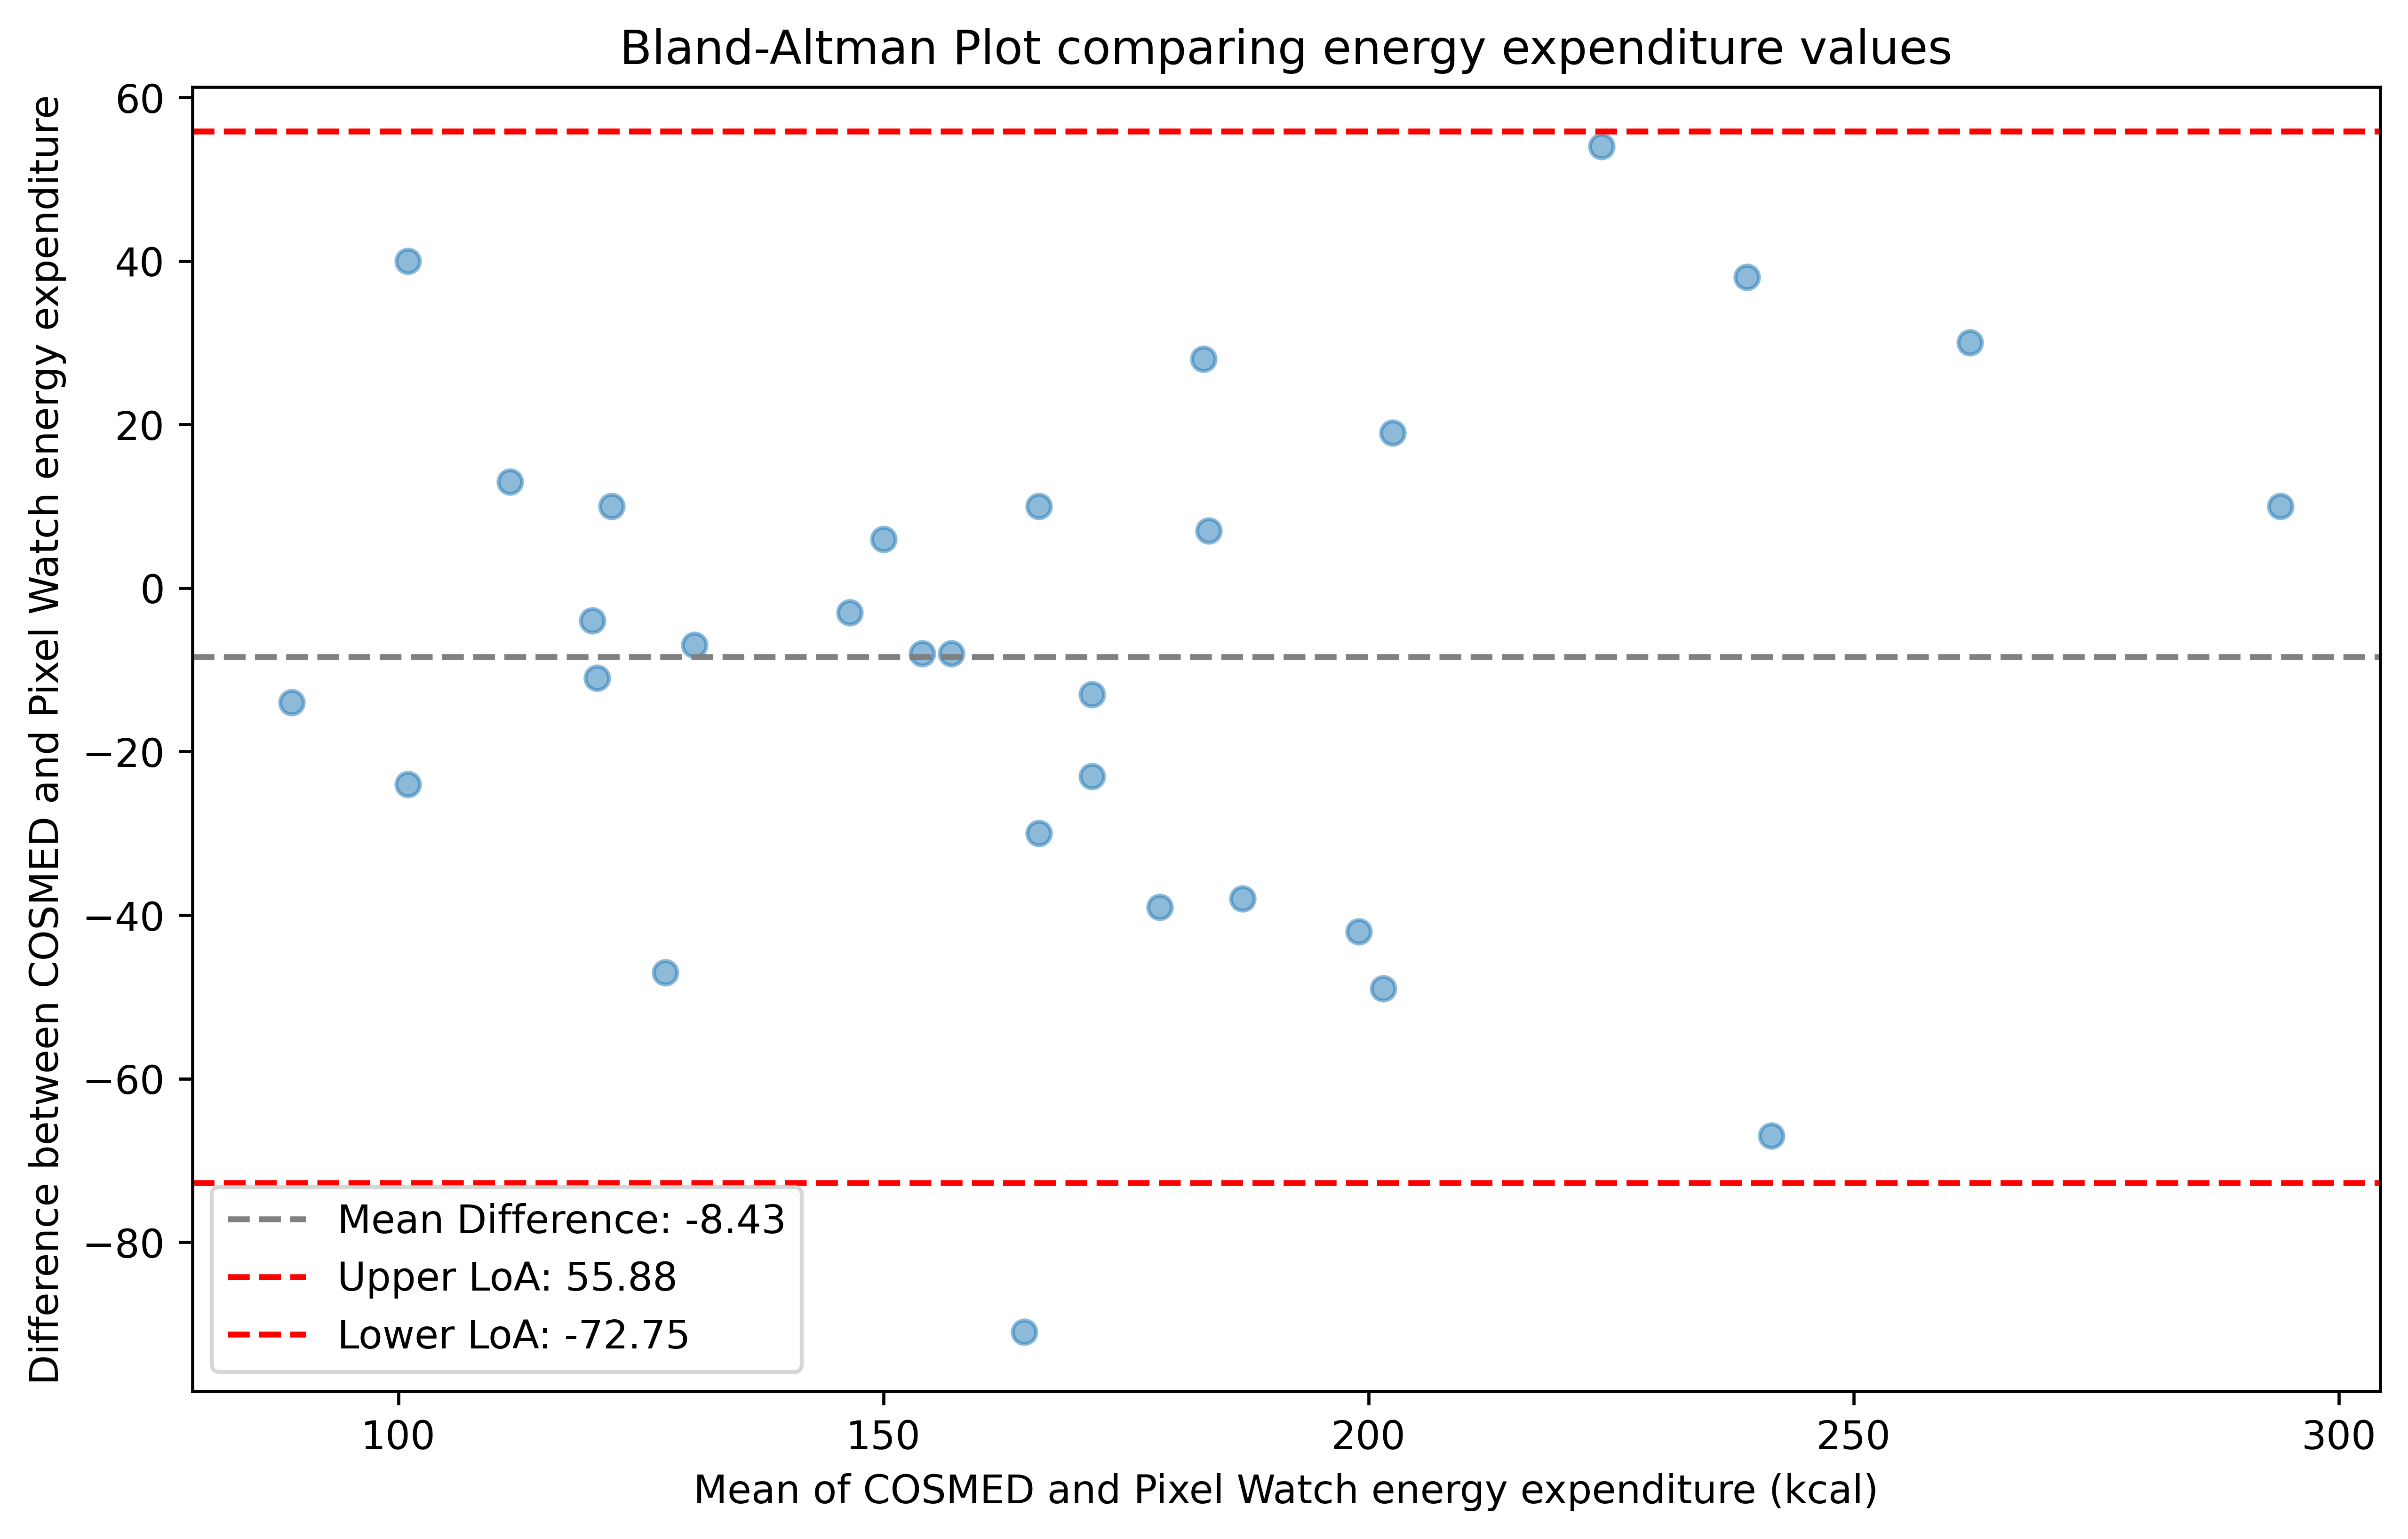

In [22]:
# Create Bland-Altman plot manually
plt.rcParams['font.family'] = 'sans-serif'
plt.figure(figsize=(10, 6), dpi=600)
plt.scatter(mean_diff_values, diff, alpha=0.5)
plt.axhline(mean_diff, color='gray', linestyle='--', label=f'Mean Difference: {mean_diff:.2f}')
plt.axhline(loa_upper, color='red', linestyle='--', label=f'Upper LoA: {loa_upper:.2f}')
plt.axhline(loa_lower, color='red', linestyle='--', label=f'Lower LoA: {loa_lower:.2f}')
plt.title('Bland-Altman Plot comparing energy expenditure values')
plt.xlabel('Mean of COSMED and Pixel Watch energy expenditure (kcal)')
plt.ylabel('Difference between COSMED and Pixel Watch energy expenditure')
plt.legend()
plt.savefig("pixelwatch_blandAlt_plot")
plt.show()

## Mean average percentage error (MAPE)

### MAPE function

In [23]:
def calculate_mape(cosmed, pixelwatch):
    cosmed, pixelwatch = np.array(cosmed), np.array(pixelwatch)
    return np.mean(np.abs((cosmed - pixelwatch) / cosmed)) * 100

In [24]:
mape = calculate_mape(df['cosmed_ee'], df['pixel_ee'])
print(f'MAPE: {mape:.4f} %')
print(f'Number of participants: {len(df['cosmed_ee'])}')

MAPE: 15.0165 %
Number of participants: 30


#### Manual MAPE calculation

In [25]:
absolute_errors = df['cosmed_ee'] - df['pixel_ee'].abs()

In [26]:
# Calculate absolute percentage errors
absolute_percentage_errors = (absolute_errors.abs() / df['cosmed_ee']) * 100

In [27]:
# Sum the absolute percentage errors
sum_absolute_percentage_errors = absolute_percentage_errors.sum()

# Get the total number of data points
total_data_points = len(absolute_percentage_errors)

In [28]:
# Calculate MAPE
mape = sum_absolute_percentage_errors / total_data_points

In [29]:
# Calculate standard error
mean_absolute_error_diff = absolute_errors.mean()
std_diff = absolute_errors.std()
n = len(absolute_errors)
se_diff = std_diff / np.sqrt(n)

In [30]:
# Calculate standard deviation and standard error for MAPE
std_percentage_error = absolute_percentage_errors.std()
n = len(absolute_percentage_errors)
se_percentage_error = std_percentage_error / np.sqrt(n)

In [31]:
# Calculate the t critical value for a 95% confidence level
t_critical = t.ppf(0.975, df=n-1)  # 0.975 corresponds to 95% two-tailed

# Calculate 95% CI for the mean difference
# ci_upper = mean_diff + 1.96 * se_diff
# ci_lower = mean_diff - 1.96 * se_diff

ci_upper = mape + (t_critical * se_percentage_error)
ci_lower = mape - (t_critical * se_percentage_error)

In [32]:
print(f"MAPE for energy expenditure is: {mape:.4f} %")
print(f"95% confidence intervals for the absolute error: {ci_lower:.2f}, {ci_upper:.2f}")
print(f"The standard error of the differences is {se_diff:.2f}")

MAPE for energy expenditure is: 15.0165 %
95% confidence intervals for the absolute error: 10.70, 19.33
The standard error of the differences is 5.99


#### Plot of absolute percentage error by participant:

In [35]:
df['absolute_percentage_errors'] = (absolute_errors.abs() / df['cosmed_ee']) * 100

fig = px.bar(
    df,
    x='participant_id',
    y='absolute_percentage_errors',
    title='Absolute percentage error by participant (energy expenditure)',
    labels={"participant_id": 'Participant', "absolute_percentage_errors": 'Absolute percentage error (%)'},
    color="absolute_percentage_errors",
    color_continuous_scale='Turbo'
)

tickvals = list(range(len(df["participant_id"].unique())))
ticktext = [f"P{i+1}" for i in tickvals]

fig.update_xaxes(
    tickmode="array",
    tickvals=tickvals,
    ticktext=ticktext
)

fig.show()

In [53]:
df['error'] = (df['cosmed_ee'] - df['pixel_ee']).abs()

fig = px.scatter(
    data_frame=df,
    x='cosmed_ee',
    y='absolute_percentage_errors',
    title='Absolute percentage error VS energy expenditure value by participant',
    labels={"cosmed_ee": 'Criterion EE value', "absolute_percentage_errors": 'Absolute percentage error (%)'},
    color="absolute_percentage_errors",
    color_continuous_scale='Turbo',
)

fig.update_traces(marker=dict(size=8))

fig.update_layout(
    height=600,
    width=1200
)

fig.show()

In [57]:
fig = px.box(
    data_frame=df,
    y='error',
    title='Absolute error distribution for energy expenditure',
    labels={'error': 'Absolute error (kcal)'}
)

# Compute summary stats
median_val = df['error'].median()
min_val = df['error'].min()
max_val = df['error'].max()

fig.add_annotation(
    x=0.02,
    y=max_val,
    text=f"Max: {max_val:.2f}",
    showarrow=False,
    xanchor='left'
)

fig.add_annotation(
    x=0.02,
    y=median_val + 1,
    text=f"Median: {median_val:.2f}",
    showarrow=False,
    xanchor='left'
)

fig.add_annotation(
    x=0.02,
    y=min_val + 1,
    text=f"Min: {min_val:.2f}",
    showarrow=False,
    xanchor='left'
)

fig.update_layout(
    height=700,
    width=800
)

fig.show()

In [ ]:
# Divide the sum by the total number of data points
mae = absolute_errors.abs().mean()
print(mae)

25.379310344827587


##### MAE from sklearn

In [ ]:
from sklearn.metrics import mean_absolute_error

y_true = df['cosmed_ee']
y_pred = df['pixel_ee']
# Using the same data as above
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE from scikit-learn: {mae}')

MAE from scikit-learn: 25.379310344827587


##### 95% CI for MAE

In [ ]:
# ** CALCULATE 95% CONFIDENCE INTERVAL **
# Calculate the standard deviation of the absolute errors
std_dev = absolute_errors.abs().std(ddof=1)

# Calculate the standard error of the mean (SEM)
n = len(absolute_errors)
sem = std_dev / np.sqrt(n)

# 8. Determine the t-critical value for a 95% confidence interval
confidence = 0.95
degrees_freedom = n - 1
alpha = 1 - confidence
t_crit = stats.t.ppf(1 - alpha/2, degrees_freedom)

# Calculate the margin of error
# Usually, margin of error = 1.96 * sem, but for smaller populations, t_crit is more appropriate
margin_of_error = t_crit * sem

# Compute the 95% confidence interval
lower_bound = mae - margin_of_error
upper_bound = mae + margin_of_error

In [ ]:
print(f"The Mean Absolute Error for energy expenditure is {mae:.4f} kcal.")
print(f"The 95% confidence interval is ({lower_bound:.4f}, {upper_bound:.4f}) kcal.")
print(f"t-critical value: {t_crit:.4f}")

The Mean Absolute Error for energy expenditure is 25.3793 kcal.
The 95% confidence interval is (17.3511, 33.4076) kcal.
t-critical value: 2.0484
